# 2. Exploratory Data Analysis 

Here, we analyze the socio-economic and geographic data provided by Manifold as well as our Foundation's data at the postal code level for all of BC (2016-2017). We focus mostly on postal codes where donations have ranged between 1,000 and 10,000 dollars. 

We aim to answer the following questions:

* How are different variables related to charitable contributions? 
* What do postal codes that donate the most to charity have in common?
* Are there some postal codes that have high capacity (our most common measure for asking for donations) but low charitable contributions? Why is this the case?

In [168]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns 
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
%matplotlib inline 

In [169]:
import os
os.chdir('M:\\PH-RPM\\Elba\\Data\\')
data= pd.read_csv('MANIFOLD_BC_ALL.csv')

In [ ]:
#list(data)

### Feature Engineering
Here I generate a child proportion ratio in order to measure how many children there are in a particular neighbourhood. This could be relevant regarding donations to the Children's Hospital.

In [170]:
data['ChildPopRatio'] = (( data['Population_Total'] - data['Pop_15_plus'])/data['Population_Total'])

In [171]:
data['HH_Inc_1'] = data['HH_Inc_1']/data['Dwellings_Tot']
data['HH_Inc_2'] = data['HH_Inc_2']/data['Dwellings_Tot']
data['HH_Inc_3'] = data['HH_Inc_3']/data['Dwellings_Tot']
data['HH_Inc_4'] = data['HH_Inc_4']/data['Dwellings_Tot']
data['HH_Inc_5'] = data['HH_Inc_5']/data['Dwellings_Tot']
data['HH_Inc_6'] = data['HH_Inc_6']/data['Dwellings_Tot']
data['HH_Inc_7'] = data['HH_Inc_7']/data['Dwellings_Tot']
data['HH_Inc_8'] = data['HH_Inc_8']/data['Dwellings_Tot']
data['HH_Inc_9'] = data['HH_Inc_9']/data['Dwellings_Tot']
data['HH_Inc_10'] = data['HH_Inc_10']/data['Dwellings_Tot']
data['HH_Inc_11'] = data['HH_Inc_11']/data['Dwellings_Tot']
data['HH_Inc_12'] = data['HH_Inc_12']/data['Dwellings_Tot']
data['HH_Inc_13'] = data['HH_Inc_13']/data['Dwellings_Tot']

I also want a variable that measures the proportion of individuals that are of a certain income level within a particular postal code.

I want to aggregate the measure above further into percentage of high, medium and low income percentage of individuals within a postal code. 

In [172]:
data['HH_Inc_Low'] =  data['HH_Inc_1'] + data['HH_Inc_2'] + data['HH_Inc_3'] + data['HH_Inc_4'] \
+ data['HH_Inc_5']  + data['HH_Inc_6'] 
data['HH_Inc_Med'] =  data['HH_Inc_7'] + data['HH_Inc_8'] + data['HH_Inc_9'] + data['HH_Inc_10'] 
data['HH_Inc_High'] = data['HH_Inc_11'] + data['HH_Inc_12'] + data['HH_Inc_13']

Finally, I extracted the following additional variables from our dataset: *Owned vs Rented dwelling* and *Age of Household Mantainer*. These variables can give us a good idea of an average Postal Code financial status and most importantly the average age of the houshold owner by postal code. I convert them to percentages to account for the differences in dwellings per postal code. 

In [173]:
#Household ownership 
data['Owned_Dwelling_Percent'] = data['Owned-Count-PC']/data['Dwellings_Tot']
data['Rented_Dwelling_Percent'] = data['Rented-Count-PC']/data['Dwellings_Tot']
data['Band_Dwelling_Percent'] = data['Band housing-Count-PC_y']/data['Dwellings_Tot']
#
data['Older_HH_Owners_Percent'] = (data['Tot_Priv_HH_Age_55-64'] + data['Tot_Priv_HH_Age_65-74'] + \
                                   data['Tot_Priv_HH_Age_75_o'])/data['Dwellings_Tot']
data['Younger_HH_Owners_Percent'] = (data['Tot_Priv_HH_Age_25-34'] + data['Tot_Priv_HH_Age_35-44'] + \
                                     data['Tot_Priv_HH_Age_u_25'] + data['Tot_Priv_HH_Age_45-54']  )/data['Dwellings_Tot']
data['Most_Senior_Owner_Percent'] = data['Tot_Priv_HH_Age_75_o']/data['Dwellings_Tot']

## How different variables relate to charitable contributions (all BC)


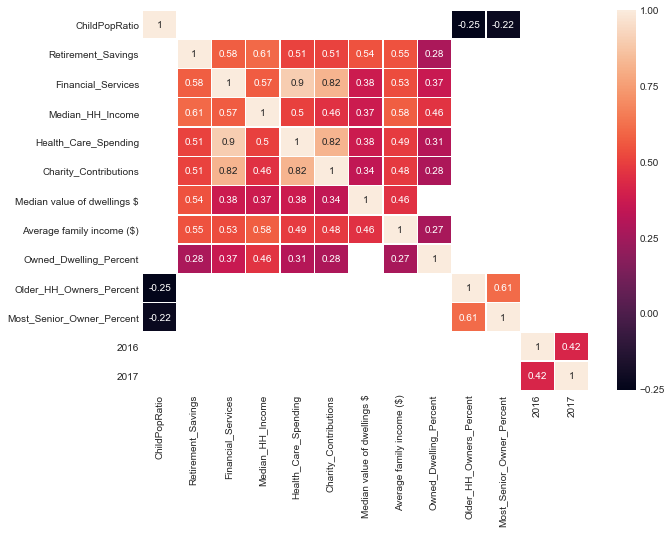

In [174]:
#Looking at correlation between variables
data1 =data[["ChildPopRatio", "Retirement_Savings" ,"Financial_Services", "Median_HH_Income","Health_Care_Spending",\
             "Charity_Contributions",'Median value of dwellings $', 'Average family income ($)', 'Owned_Dwelling_Percent', \
            'Older_HH_Owners_Percent','Most_Senior_Owner_Percent', '2016', '2017']] 

corr = data1.corr()

mask = np.absolute(corr) > 0.20
fig, ax = plt.subplots(figsize=(10,7)) # Sample figsize in inches

sns.heatmap(corr[mask], 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True,  linewidths=.5,ax=ax)
plt.show()


 Now we plot several variabeles to see their frequency distribution. Note the plot for BCCH 2016 contributions- the histogram seems oddly distributed. It'd be intersting to look at it further-since this will be our primary dependent variable.

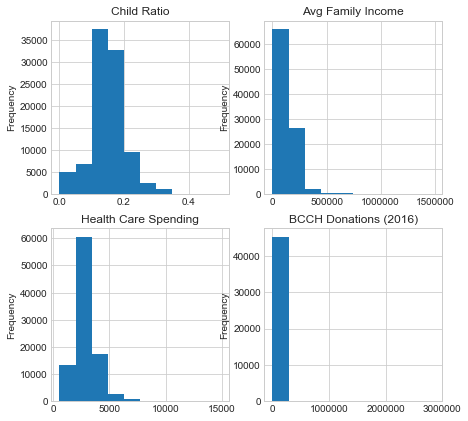

In [175]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(7, 7))
data1['ChildPopRatio'].plot(ax=axes[0,0], kind='hist' ); axes[0,0].set_title('Child Ratio');
data1['Average family income ($)'].plot(ax=axes[0,1],kind='hist'); axes[0,1].set_title('Avg Family Income');
data1["Health_Care_Spending"].plot(ax=axes[1,0],kind='hist'); axes[1,0].set_title('Health Care Spending');
data1["2016"].plot(ax=axes[1,1],kind='hist'); axes[1,1].set_title('BCCH Donations (2016)');

In [176]:
#We take the top 10% of the donations ('Charitable Contributions')
data = data.sort_values("Charity_Contributions",ascending=False)
data_top = data.iloc[0:950]
data_top= data_top[["Charity_Contributions", 'Median_HH_Income', 'Health_Care_Spending',\
                    'Financial_Services', 'ChildPopRatio','Average family income ($)',\
                    'Median value of dwellings $', 'Owned_Dwelling_Percent','Older_HH_Owners_Percent',\
                    'Most_Senior_Owner_Percent','Younger_HH_Owners_Percent', '2016', '2017']]
#print (data_top.describe())
data_all= data[["Charity_Contributions", 'Median_HH_Income', 'Health_Care_Spending', \
                'Financial_Services', 'ChildPopRatio','Average family income ($)',\
                'Owned_Dwelling_Percent','Older_HH_Owners_Percent','Most_Senior_Owner_Percent',\
                'Younger_HH_Owners_Percent','2016', '2017']]
#print (data_all.describe())
#We take the top 10% of the donations ('BCCH 2016')
#data[['Charity_Contributions','ChildPopRatio']].head(1000)

In [177]:
data = data.sort_values("2016",ascending=False)
data_top_bcch = data.iloc[0:950]
data_top_bcch= data_top_bcch[["Charity_Contributions", 'Median_HH_Income', \
                              'Health_Care_Spending', 'Financial_Services', \
                              'ChildPopRatio','Average family income ($)',\
                              'Median value of dwellings $', 'Owned_Dwelling_Percent',\
                              'Older_HH_Owners_Percent','Most_Senior_Owner_Percent',\
                              'Younger_HH_Owners_Percent', '2016', '2017']]
#print (data_top_bcch.describe())

Note that if we focus on the top 10% of individuals donating to BC Children's in 2016, we still have an uninformative histogram. 
If we remove the 'outliers', namely constituents that donated **more** than 10,000 in a given year, we obtain figure 2. Here we can observe a consistent decline in frequency of donatiosns from 3,000 to 10,000 - where there are spikes both at 3,000 and 5,000. 

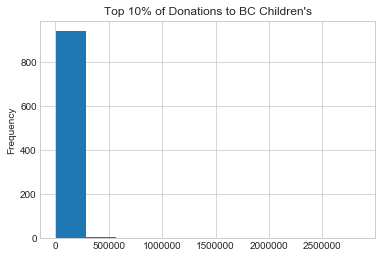

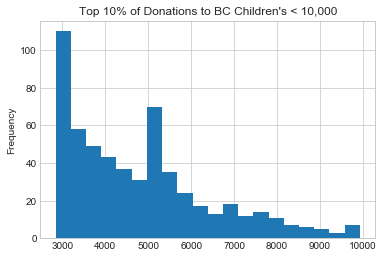

In [178]:
Top_minus_outliers = data_top_bcch['2016'] < 10000
data_top_trunc = data_top_bcch[Top_minus_outliers]

data_top_bcch.hist(column='2016', bins=10)
plt.title("Top 10% of Donations to BC Children's")
plt.ylabel('Frequency')
data_top_trunc.hist(column='2016', bins=20)
plt.title("Top 10% of Donations to BC Children's < 10,000")
plt.ylabel('Frequency')
plt.show()

## How do the most charitable postal code look like? Top 10% in BC
Here, we selected the top 10% of postal codes that spend the most in lieu of charitable contributions per year that donated less than 10,000. We can observe that by all measures, these individuals don't stray too far away from the BC average in terms of age, income, and health care spending.

| Variable  | Top 10% Mean_CC | Top 10% SD CC |All PC Mean |All PC SD | Top 10% Mean_BCCH <10000 |Top 10% SD_BCCH <10000 |
|----------|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
| Average Charitable Contribution  | 4,463 | 1,131|991|500 |1079|709|
| Median_HH_Income  |148,736 | 49,549|76,853|29,233 |80,718|35,513|
| Health_Care_Spending |     7,222  | 1,485 |2,903|1002 |3,112|1,237|
| Financial_Services    |   1,937  |404|712|272|778|341|
| Percentage of Children   |   12% |6% |14%|5%|14%|4%|
|Average family income ($) |   400,000  |216,000 |137,000|82,500|164,500|144,300|
|Owned_Dwelling_Percent |   90%  |11% |76%|21%|76%|20%|
|Old_Household_Owners |  56%  |28% |40%|20%|44%|21%|
|Most_Senior_Owner |  15%  |16% |9%|13%|10%|12%|
|Younger_HH_Owners_Percent  | 32%  |22% |52%|24%|51%|22%|
|2016 Donations to BC Childrens  |1,860  |9,720 |798|18,800|4,796|1,659|
|2017 Donations to BC Childrens  |1,133 |6,009 |400|7,139|2,820|3,082|

In [ ]:
## Scatterplot matrix 
#sns.set(style="ticks")
#sns.pairplot(data1)
#sns.pairplot(data1, hue="species")

# Prediction 
Now that we have a better understanding of our dataset, we can go ahead and fit a multivariate model to see how well it predicts  our dependent variable: total contributions to BC Children's in 2016.

* Note that the MSE actually **increased** when we included the additional features we extracted and engineered.  This means that we are ovefitting 
* Since there are many variables that are highly correlted amongst each other, I will run PCA on our variables and then re-run the regression, so we tackle multicollinearity and also have a more  parsimonious model

If we run this model with charity contributions as the outcome variable, we have 


Some comments:
* It looks like the prediction is much improved by only including 2017 but not the inverse (predicting 2017 based on 2016). I wonder what it's tapping into? Well by construction you only get 2017 if you have 2016
* Also note that we can't really accurately predict 2017 because it's only non-zero if the individual also donated in the past year

In [179]:
# Import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#First, we want to convert the nulls (postal codes that didn't donate in 2016/2017) to zeros
data['2016'].isnull().sum()
data['2016'] = data['2016'].fillna(0)
data['2017'] = data['2017'].fillna(0)

#### Testing benchmark and alternative models with BCCH donations in 2016 as the outcome variable 
X1 = data[['Median_HH_Income','Health_Care_Spending', 'Financial_Services','Gifts_Money', \
          'Charity_Contributions','Retirement_Savings' ]] 

X2 = data[['Charity_Contributions','Average family income ($)', \
          "Retirement_Savings" ,"Financial_Services","Health_Care_Spending",\
          'Owned_Dwelling_Percent','Older_HH_Owners_Percent']] 

list = [X1, X2]

for X in list:
    # Create training and test sets
    y = data['2016']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    # Create the regressor: reg_all
    reg_all = LinearRegression()

   # Fit the regressor to the training data
    reg_all.fit(X_train, y_train)

    # Predict on the test data: y_pred
    y_pred = reg_all.predict(X_test)

    # Compute and print R^2 and RMSE
    print("R^2: {}".format(reg_all.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error: {}".format(rmse))
    

R^2: -0.002325310845206374
Root Mean Squared Error: 3602.39865391582
R^2: -0.002396472496880575
Root Mean Squared Error: 3602.526530606926


In [180]:
#### Testing benchmark and alternative models with Charity Contributions in 2017 as the outcome variable 

M1 = data[['Median_HH_Income','Health_Care_Spending', 'Financial_Services','Gifts_Money', \
          'Retirement_Savings', '2016']] 

M2 = data[['Average family income ($)', "ChildPopRatio", \
          "Retirement_Savings" ,"Financial_Services","Health_Care_Spending",\
          'Owned_Dwelling_Percent','Older_HH_Owners_Percent','2016','Gifts_Money']] 

list = [M1, M2]

for X in list:
    # Create training and test sets
    y = data['Charity_Contributions']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    # Create the regressor: reg_all
    reg_all = LinearRegression()

   # Fit the regressor to the training data
    reg_all.fit(X_train, y_train)

    # Predict on the test data: y_pred
    y_pred = reg_all.predict(X_test)

    # Compute and print R^2 and RMSE
    print("R^2: {}".format(reg_all.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.8570875104418146
Root Mean Squared Error: 204.58021004414738
R^2: 0.857968057217605
Root Mean Squared Error: 203.94898184537257


### Crossvalidation
Now we want to do some cross validation in order to ensure that our training/testing split is optimal. 

From wikipedia: "The goal of cross-validation is to test the model’s ability to predict new data that were not used in estimating it, in order to flag problems like overfitting and to give an insight on how the model will generalize to an independent dataset (i.e. an unknown dataset, for instance from a real problem)." 

Basically, what cross-validation does here, is take different subsets of the data to split into training/testing (five times). Each time this outputs an $R^2$. Then we just average the $R^2$ to get an overall measure of performance. 

In [14]:
# Import the necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X,y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-53.54914555   0.86090556   0.81793206  -2.45269902   0.20187892]
Average 5-Fold CV Score: -10.824225608084209


### Now, let's try PCA for regessor dimension reduction

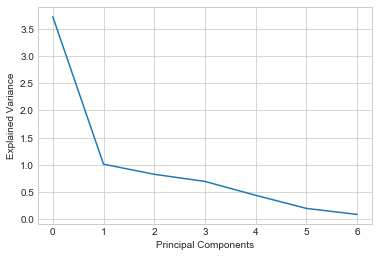

In [181]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import scale
# run an initial PCA to find the number of components to run with
pca = PCA()

#fit the model to our X2 data and standardize 
pca_features = pca.fit_transform(scale(X2))

m = pca.components_

# looks like we want to two one PC.
plt.plot(pca.explained_variance_)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')

plt.show()

In [182]:
pca = PCA(n_components=2)

#drop year and aggregate by neighbourhood. Here we want a spatial pca.
pca_features = pca.fit(scale(X2))

m = pca.components_

pcs = pd.DataFrame(pca.transform(scale(X2)))

geographical_srq_pcs = pd.concat((X2,pcs), axis=1)

# merge the loadings together. This allows for direct interpretation of the loadings later.
all_loadings = -1 * pca.components_.T * np.sqrt(pca.explained_variance_)

# transpose and convert to a DF. The columns will be the variables, rows will be PCs. Each cell gives loading of a given variable into a given PC 
all_loadings = pd.DataFrame(all_loadings.T, columns=X2.columns.values)

#all_loadings

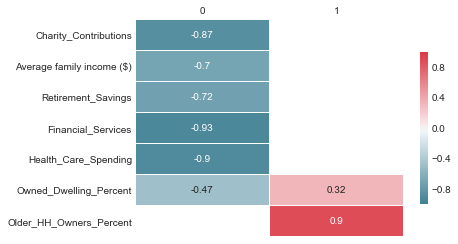

In [183]:
#we set style for a nicer matrix 
sns.set_style("whitegrid")

# create our colour map.
cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.absolute(all_loadings) > 0.3

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(all_loadings[mask].T, cmap=cmap, center=0, vmax = 1, vmin = -1, annot=True,
             linewidths=.5, cbar_kws={"shrink": .7}, )

ax.xaxis.set_ticks_position('top')

plt.show()

In [184]:
X_PC = geographical_srq_pcs.iloc[:,[7,8]]
y = data['2016']

 # Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_PC, y, test_size = 0.3, random_state=42)
y = data['2016']
    
# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE: we observe a marginal improvement from our benchmark model- but nothing significant
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: -0.0020673738429968225
Root Mean Squared Error: 3601.9351059606647


### Decision Tree Regression
From the PCA regression above we can observe that there was only marginal improvement compared to our benchmark model. Our final approach will be to try Random Forest and Decision Tree regressions with boosting.

In [185]:
rng = np.random.RandomState(1)
rng

In [186]:
# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from numpy import *

y= data['2016']

X1_R = data[['Median_HH_Income','Health_Care_Spending', 'Financial_Services','Gifts_Money', \
          'Charity_Contributions','Retirement_Savings' ]] 

X2_R = data[['Charity_Contributions','Average family income ($)', \
          "Retirement_Savings" ,"Financial_Services","Health_Care_Spending",\
          'Owned_Dwelling_Percent','Older_HH_Owners_Percent']] 

list = [X1_R, X2_R]

X_train, X_test, y_train, y_test = train_test_split(X1_R, y, test_size=0.3, random_state=rng)

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=8,
             min_samples_leaf=.13,  random_state=rng)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute mse_dt
mse_dt = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_dt = mse_dt_1**(1/2)
rmse_dt

8381.58792964463

In [188]:
X_PC = geographical_srq_pcs.iloc[:,[7,8]]

# Import DecisionTreeRegressor from sklearn.tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as MSE
from numpy import *

y= data[ '2016']
X2_R = data[['Owned_Dwelling_Percent','Older_HH_Owners_Percent']]
list = [X1_R, X2_R]

X_train, X_test, y_train, y_test = train_test_split(X_PC, y, test_size=0.3,random_state=rng)

# Instantiate dt
dt_1 = DecisionTreeRegressor(max_depth=8,
             min_samples_leaf=.13,
         random_state=rng )

# Fit dt to the training set
dt_1.fit(X_train, y_train)

# Compute y_pred
y_pred = dt_1.predict(X_test)

# Compute mse_dt
mse_dt_1 = MSE(y_test, y_pred)

# Compute rmse_dt
rmse_dt_1 = mse_dt_1**(1/2)
rmse_dt_1

22126.93242212593

Now, we need to implement boosting in order for the results to 

### Auto ML

In [ ]:
#Do random forest and then notebook conclusions (wrap up this analysis)

In [ ]:
X_PC